# Bandit算法学习[网站优化]03——Softmax 算法

## 参考资料

1. White J. Bandit algorithms for website optimization[M]. " O'Reilly Media, Inc.", 2013.
2. [https://github.com/johnmyleswhite/BanditsBook](https://github.com/johnmyleswhite/BanditsBook)

实验环境：jupyter python 3.7


## 一、Softmax算法介绍

epsilon-Greedy算法有一个明显的问题：它完全随机地`explore`选项，而不考虑它们的优点。例如，在一个场景(称为场景A)中，可能有两只臂，其中一只臂有10%的时间奖励我们，另一只臂有13%的时间奖励我们。在场景B中，这两个手臂可能会在10%的时间和99%的时间奖励我们。在这两种情况下，epsilon-Greedy算法`explore`较差的臂的概率是完全相同的(epsilon/2)，尽管相对而言，场景B中的较差臂比场景A中的较差臂差得多。

这对我们来说是一个问题，原因如下：

+ 如果两个臂之间的奖励率差异很小，我们需要花比10%更多的时间去`explore`，才能正确地确定哪一个实际上更好

+ 相比之下，如果两个臂之间的奖励率差异很大，我们需要`explore`不到10%的时间来正确估计这两个选项中更好的一个。出于这个原因，在这种情况下，你会因为探索一个毫无疑问的劣势选项而失去很多奖励。当我们第一次描述epsilon-Greedy算法时，我们说不会精确地设置epsilon=1.0，这样就不会把时间浪费在较差的选项上，但是，**如果两臂之间的奖励率差异足够大，我们最终也会将时间浪费在较差的选项上，因为epsilon-Greedy算法总是随机地完全`explore`**。

因此，我们需要结构化的`explore`，而不是epsilon-Greedy算法提供的随意的`explore`。

我们将描述的第一个考虑这种结构信息的算法称为Softmax算法。**Softmax算法试图通过将有关可用臂的奖励率的信息明确纳入其探索时`explore`哪个臂的方法中，来处理奖励率不同的臂**。

可以根据估计值按比例选择每个臂，从而初步了解Softmax算法如何处理此问题。假设有两只臂，A和B。根据你过去的经验，这两只臂有两种不同的成功率：$rA$和$rB$。有了这些假设，类似Softmax算法的最简单的实现：以概率为$rA/(rA+rB)$选择臂 A和以概率为$rB/(rA+rB)$选择臂B。代码编写如下：

```python
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i

    return len(probs) - 1


def select_arm(self):
    z = sum(self.values)
    probs = [v / z for v in self.values]
    return categorical_draw(probs)
```

实际上，上述算法并非实际使用的算法，我们需要对其进行两处更改。

首先，对$rA$和$rB$的估计进行指数化，计算出一个不同的奖励率比例。以$\exp(rA)/(\exp(rA) + \exp(rB))$的概率选择手臂A，以$\exp(rB)/(\exp(rA) + \exp(rB))$的概率选择手臂B。使用指数重构的优点是，如果使用负数作为成功率也不会影响，因为对$exp$的调用会把任何负数变成正数，并确保分母中的负数不能抵消分母中的任何正数。

更重要的是，这种指数化的技巧使我们非常接近完整的Softmax算法。事实上，如果你对标准Softmax算法所拥有的可配置参数之一进行硬编码，那么普通的指数重构就能给我们提供Softmax算法。这个额外的参数是与我们刚才介绍的指数化不同的一种**缩放因子**。这种新类型的比例因子通常被称为**温度参数**(temperature)，这是基于物理学的类比，即系统在高温下往往表现得很随意，而在低温下则表现得更有结构性。事实上，完整的Softmax算法与物理学中一个叫做`玻尔兹曼分布`的概念密切相关，它被用来描述粒子群的行为方式。

称这个新的温度参数为$\text{tau}$。我们引入$\text{tau}$来产生以下新算法：

+ 在时间T处，选择两个臂之一，其概率计算如下：

  + $\exp(rA/\text{tau})/(\exp(rA/\text{tau}) + \exp(rB/\text{tau}))$
  + $\exp(rB/\text{tau})/(\exp(rA/\text{tau}) + \exp(rB/\text{tau}))$

+ 对于选择的任何一条臂，使用我们用于epsilon-Greedy算法的相同更新规则来更新对平均值的估计。


## 二、Softmax算法的应用

上述算法的实际编码如下：

In [3]:
import math
import random


def categorical_draw(probs):
    """  
    根据probs按比例以一定概率选择臂
    """
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i

    return len(probs) - 1


class Softmax:
    def __init__(self, temperature, counts, values):
        self.temperature = temperature
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

    def select_arm(self):
        total = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / total for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        """更新算法

        Args:
            chosen_arm: 最近选择的arm的索引
            reward: 选择该arm获得的奖励
        """        
        # 选择次数增加
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        # 加权平均
        new_value = ((n-1)/float(n))*value + (1/float(n)) * reward
        self.values[chosen_arm] = new_value
        return
    

接下来让我们讨论一下温度参数$\text{tau}$的作用。容易想到的是，$\text{tau}$允许我们沿着由两种极端方法来改变Softmax算法的行为。在一个极端，设置$\text{tau}=0.0$。这将完全确定地选择具有最高估计值的臂。在另一个极端，设置$\text{tau}=inf$，进行纯粹的随机探索。$\text{tau}$参数之所以被称为温度参数，是因为它对臂的选择的影响就像传统物理学中的温度对原子的影响：在低温下，原子会有序地行动并产生固体，但在高温下，它们的行为是随机的，会产生气体。和原子一样，**Softmax算法在低温下的行为是有序的，而在高温下基本上是随机的**。

## 三、衡量Softmax算法的表现

### 3.1 方法1：跟踪选择最佳arm的概率

![image-20230105111108565](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230105111108565.png)

由上图可知，等待足够长的时间，Softmax算法开始100%地选择右臂。这比epsilon-Greedy算法有了很大的改进。

### 3.2 方法2：跟踪每个时间点的平均奖励


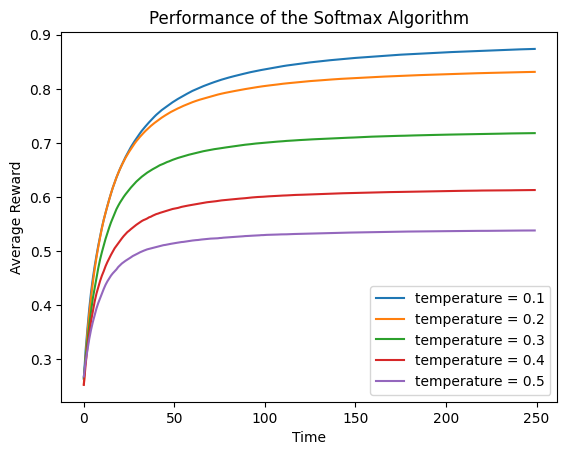

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

def get_cumulative_reward(algo, arms, num_sims, horizon):
    """测试算法框架

    Args:
        algo: 试图测试的bandit算法框架
        arms: 模拟绘制的臂的数组
        num_sims: 模拟的次数
        horizon: 每个算法在每次模拟期间被允许拉动臂的次数

    Returns:
        在每次试验中获得的平均累计奖励
    """
    result = []

    for sim in range(num_sims):
        cumulative_rewards = [0.0 for i in range(horizon)]
        algo.initialize(len(arms))
        for t in range(horizon):
            t = t + 1
            index =  t - 1

            # 选择臂
            chosen_arm = algo.select_arm()

            # 模拟拉动臂的结果
            reward = arms[chosen_arm].draw()

            # 记录算法收到的奖励金，然后调用更新
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)
        result.append(cumulative_rewards)
    
    # 多次模拟求平均
    average = np.sum(np.array(result),axis=0) / num_sims
    
    return list(average)

def draw_average_reward(arms, temperatures, num_sims=5000, times=250):
    result = []

    for temperature in temperatures:
        algo = Softmax(temperature, [], [])
        algo.initialize(len(arms))
        cumulative_rewards = get_cumulative_reward(algo, arms, num_sims, times)

        average = list(
            map(lambda x: x / (cumulative_rewards.index(x) + 1),
                cumulative_rewards))
        result.append(average)

    i = 0
    for res in result:
        plt.plot(res, label='temperature = {0}'.format(temperatures[i]))
        i += 1

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.title('Performance of the Softmax Algorithm')
    plt.show()


means = [0.1, 0.1, 0.1, 0.1, 0.9]
temperatures = [0.1, 0.2, 0.3, 0.4, 0.5]
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

draw_average_reward(arms, temperatures)

由平均奖励率图可知，奖励值被限制在0.9而不是1.0，因为测试中最好的arm相关的预期奖励率就为0.9。

### 3.3 方法3：跟踪每个时间点的累积奖励

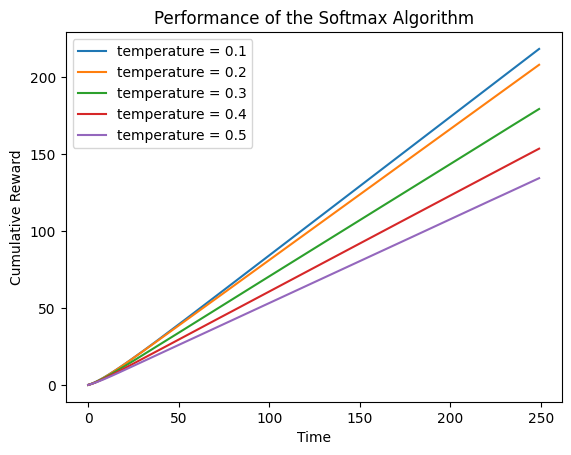

In [5]:
def draw_cumulative_reward(arms, temperatures, num_sims=5000, times=250):
    result = []

    for temperature in temperatures:
        algo = Softmax(temperature, [], [])
        algo.initialize(len(arms))
        cumulative_rewards = get_cumulative_reward(algo, arms, num_sims, times)

        result.append(cumulative_rewards)

    i = 0
    for res in result:
        plt.plot(res, label='temperature = {0}'.format(temperatures[i]))
        i += 1

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title('Performance of the Softmax Algorithm')
    plt.show()

draw_cumulative_reward(arms, temperatures)

可以看到，累计奖励相较于epsilon-Greedy算法也有所提升。也可以看到，temperature因子设置为0.1比较好。

## 四、退火Softmax算法

和epsilon-Greedy算法一样，我们同样可以使用退火来优化Softmax算法。

退火的关键代码如下：

```python
t = sum(self.counts) + 1
# 模拟退火
temperature = 1 / math.log(t + 0.0000001)
```

初始时，temperature被设置的十分大，Softmax算法近乎完全随机`explore`，但是，随着时间的推进，温度会越来越低。因为我们使用对数，这种下降并不是非常迅速。

具体的代码如下：

In [6]:
import math
import random


def categorical_draw(probs):
    """  
    根据probs按比例以一定概率选择臂
    """
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i

    return len(probs) - 1


class AnnealingSoftmax:
    def __init__(self, counts, values):

        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

    def select_arm(self):
        t = sum(self.counts) + 1
        # 模拟退火
        temperature = 1 / math.log(t + 0.0000001)
        total = sum([math.exp(v / temperature) for v in self.values])
        probs = [math.exp(v / temperature) / total for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        """更新算法

        Args:
            chosen_arm: 最近选择的arm的索引
            reward: 选择该arm获得的奖励
        """
        # 选择次数增加
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        # 加权平均
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return


运行结果如下：

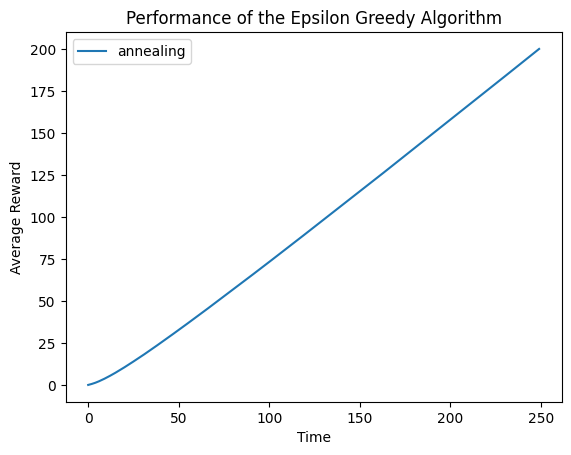

In [8]:
# seed( ) 用于指定随机数生成时所用算法开始的整数值，如果使用相同的seed( )值，
# 则每次生成的随即数都相同
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))

algo = AnnealingSoftmax([], [])
algo.initialize(n)
cumulative_rewards = get_cumulative_reward(algo, arms, 5000, 250)

plt.plot(cumulative_rewards, label='annealing')


plt.legend()
plt.xlabel('Time')
plt.ylabel('Average Reward')
plt.title('Performance of the Epsilon Greedy Algorithm')
plt.show()

虽然上图的累计奖励并没有选择temperature=0.1时多，但是我们要知道，我们并不知道最佳的temperature因子应该设置为多少，而是需要一次次的尝试，这在实际的应用中是十分费时的，而退火算法可以帮助我们进一步简化因子选择的过程。

## 五、进一步探索算法

### 5.1 不同臂的奖励概率近似时



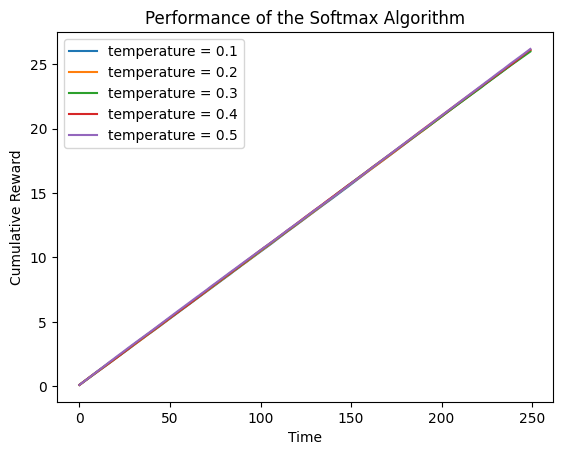

In [9]:
means = [0.1, 0.1, 0.1, 0.1, 0.12]
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))
draw_cumulative_reward(arms, temperatures)

可以看到，累计奖励近似于单臂的奖励概率$\times$ Time，与epsilon-Greedy算法无显著差异。

### 5.2 修改退火规则

将退火规则设置为$1/t$，运行结果如下：

<img src="https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230105154824165.png" alt="image-20230105154824165" style="zoom:50%;" />

区别不大。

使前100轮的温度为0.5，然后接下来的150轮的温度为0.1，运行结果如下：

<img src="https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230105155120598.png" style="zoom:50%;" />

可见有明显的转折。